In [125]:
from __future__ import print_function
from math import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib import pyplot as plt
import numpy as np
import math
import random
%matplotlib inline

In [134]:
# simple Variables for reuse

find_node_packet = 72
nodes_packet = 2762 # given that the peer returns 16 nodes.
distance_segments = 256 # distance segments: resolution of distance metric
k = 16 # Kademlia K variable (peers per bucket)
max_peers = distance_segments * k


## Peer Changing Algorithm

This calculation is a rough estimation of how a nodes routing tables evolve. It takes into consideration that nodes are likely receive nodes to `FINDNODE` requests that they are already familiar with.

In [135]:
# Returns the number of nodes after a node lookup round as a function of current nodes
def calc_node_change(current_nodes):
    if current_nodes < k:
        return k
    else:
        filled_buckets = current_nodes // k
        empty_buckets = distance_segments - filled_buckets
        factor = random.randint(1, empty_buckets + 1)
        return int(current_nodes + k*factor)

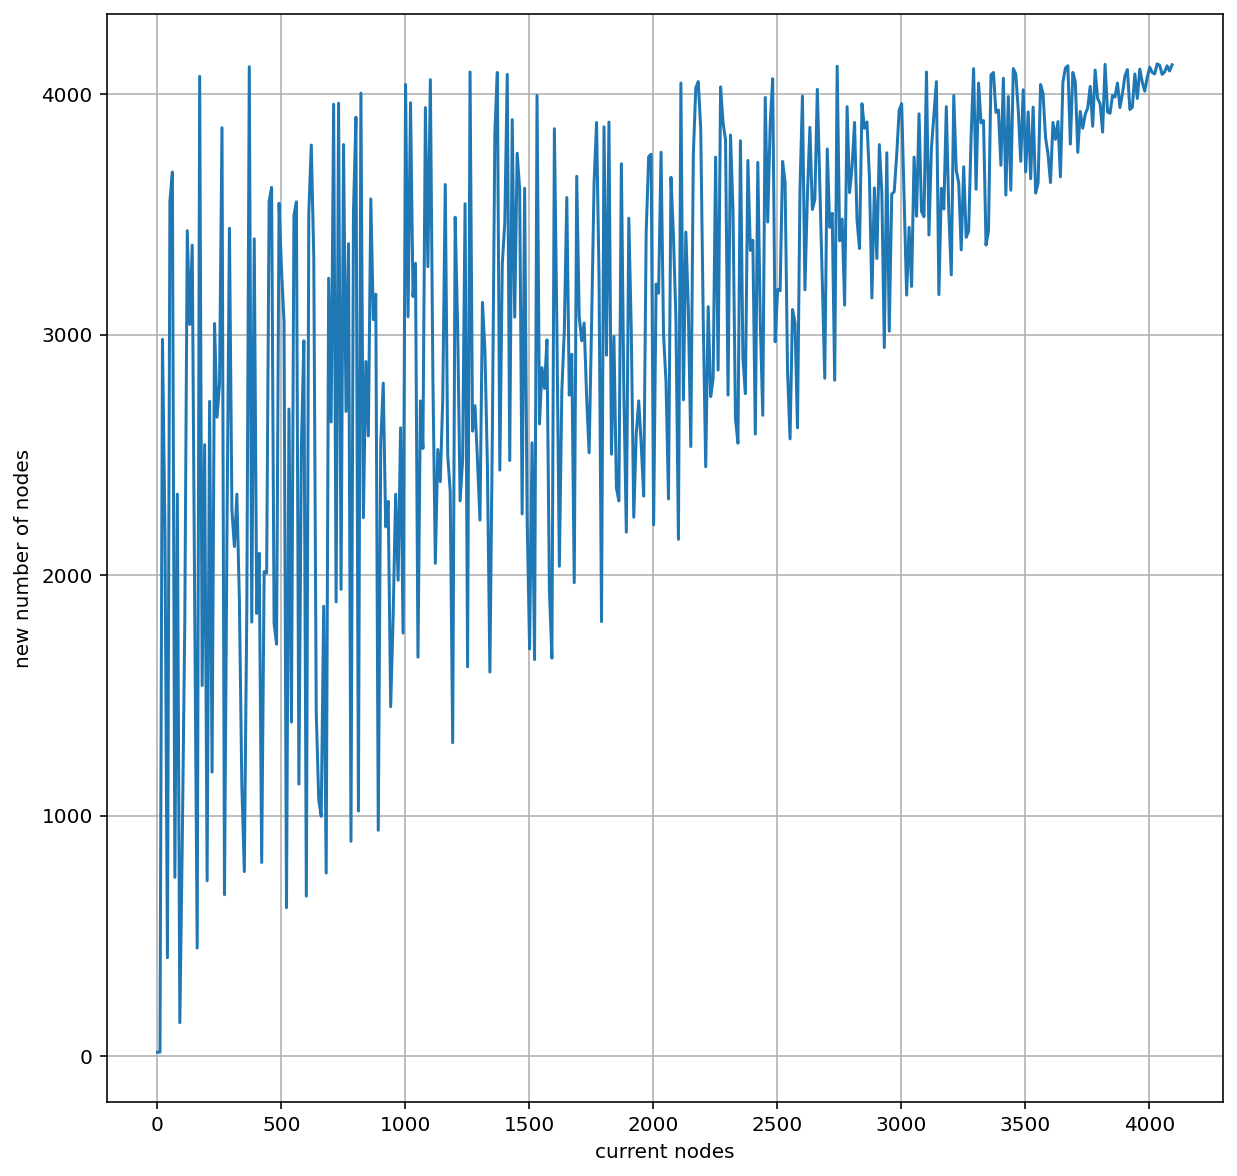

In [140]:
x = np.arange(1,max_peers,10)
y = [calc_node_change(val) for val in x]
plt.figure(figsize=[10,10])

plt.plot(x,y)
plt.xlabel('current nodes')
plt.ylabel('new number of nodes')
plt.grid(True)
plt.show()

# Bandwidth for simple lookups

This section shows us the amount of inbound and outbound bandwidth consumption used by discv5 when looking for a specific node. It uses `log2(n)` as that is the amount of Nodes needed to contact for finding a Node in Kademlia, where `n` is the amount of nodes in the network itself.

In [32]:
def calculate_bandwidth(nodes):
    num_roundtrips = ceil(log10(nodes)) # This is the theoretical efficiency

    outbound = find_node_packet * num_roundtrips
    inbound = nodes_packet * num_roundtrips

    print("B per lookup (outbound): % 2d" %(outbound))
    print("B per lookup (inbound):  % 2d" %(inbound))
    print("B per lookup (total):    % 2d" %(outbound + inbound))

interact(calculate_bandwidth, nodes=widgets.IntSlider(min=2, max=10000, step=1, value=100, description='Nodes:'))

interactive(children=(IntSlider(value=100, description='Nodes:', max=10000, min=2), Output()), _dom_classes=('…

<function __main__.calculate_bandwidth(nodes)>

*These numbers can be slightly misleading as we do not round.*

# Bandwidth for a discv5 node over a given period

This section shows how much bandwidth (roughly) a discv5 node consumes when running the protocol. This calculation is limited to `FINDNODE` & `NODE` requests, it currently does not account for `PING`s, `PONG`s or handshakes.


In [31]:
## variables

# Make the intervals configurable, so that it doesn't have to be every 60 seconds aka (1440) like right now.
#  req_freq is in seconds
#  time_period is in hours

def calc_discv5_band(num_peers, req_freq, time_period):
    node_num_reqs_per_period = int(time_period*3600 / req_freq)    # req/time_period

    out_band_per_node_per_period = (num_peers * node_num_reqs_per_period) * (find_node_packet)
    in_band_per_node_per_period = (num_peers * node_num_reqs_per_period) * (nodes_packet)
    tot_band_per_node_per_period = (num_peers * node_num_reqs_per_period) * (find_node_packet + nodes_packet)

    print("KB per period per node (outbound): {:,}".format(out_band_per_node_per_period / 1000))
    print("KB per period per node (inbound):  {:,}".format(in_band_per_node_per_period / 1000))
    print("KB per period per node (total):    {:,}".format(tot_band_per_node_per_period / 1000))

interact(
    calc_discv5_band,
    num_peers=widgets.IntSlider(min=1, max=10000, step=1, value=1, description='Peers:'),
    req_freq=widgets.IntSlider(min=30, max=600, step=1, value=60, description='Requests Frequency (s):'),
    time_period=widgets.IntSlider(min=1, max=24, step=1, value=1, description='Duration (h):')
)

interactive(children=(IntSlider(value=1, description='Peers:', max=10000, min=1), IntSlider(value=60, descript…

<function __main__.calc_discv5_band(num_peers, req_freq, time_period)>

*It is important to note that this calculation is rough, it does not take into account additional packets that are sent. Such as `PING` messages to ensure ENR records are still up to date.*